In [1]:
import numpy as np
import pandas as pd
import random

import seaborn as sns; sns.set_theme(color_codes=True)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import  TensorDataset, DataLoader
from multi_modal_loss import MultiModalLoss
import math
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import os
import random

from scipy.special import softmax
from sklearn.metrics import accuracy_score

random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

torch.cuda.set_device(0) 
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0.0001, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >self.patience:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
# GE, ME 100
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.task11= nn.Linear(2000, 500)
        self.task21= nn.Linear(2000, 500)
        self.task31= nn.Linear(2000, 500)
        
        self.task12= nn.Linear(500, 100)
        self.task22= nn.Linear(500, 100)
        self.task32= nn.Linear(500, 100)

        self.task13= nn.Linear(100, 20)
        self.task23= nn.Linear(100, 20)
        self.task33= nn.Linear(100, 20)

        self.task14= nn.Linear(20, 2)
        self.task24= nn.Linear(20, 2)
        self.task34= nn.Linear(20, 2)
        
        self.softmax  = nn.Softmax(dim=-1)

    def forward_one(self,xg,xm,xs):
        xg = self.task11(xg)
        xm = self.task21(xm)
        xs = self.task31(xs)         

        xg = self.task12(xg)
        xm = self.task22(xm)
        xs = self.task32(xs)         
        
        xg = self.task13(xg)
        xm = self.task23(xm)
        xs = self.task33(xs)      
        
        xg = self.task14(xg)
        xm = self.task24(xm)
        xs = self.task34(xs)     
        
        xg = self.softmax(xg)
        xm = self.softmax(xm)
        xs = self.softmax(xs)
        
        return xg,xm,xs

In [4]:
train_1 = pd.read_csv('/data/sim_train_1_EHH.csv', header=0, index_col=None).values
train_2 = pd.read_csv('/data/sim_train_2_EHH.csv', header=0, index_col=None).values
train_3 = pd.read_csv('/data/sim_train_3_EHH.csv', header=0, index_col=None).values

test_1 = pd.read_csv('/data/sim_test_1_EHH.csv', header=0, index_col=None).values
test_2 = pd.read_csv('/data/sim_test_2_EHH.csv', header=0, index_col=None).values
test_3 = pd.read_csv('/data/sim_test_3_EHH.csv', header=0, index_col=None).values

train_y = pd.read_csv('/data/sim_train_y_EHH.csv', header=0, index_col=None).values
test_y = pd.read_csv('/data/sim_test_y_EHH.csv', header=0, index_col=None).values

In [5]:
earlyStoppingPatience = 100
learningRate= 0.0005
weightDecay =0.0001

y_train = train_y.flatten().astype(int)
y_test = test_y.flatten().astype(int)

Xg = torch.tensor(train_1, dtype=torch.float32).cuda()
Xm = torch.tensor(train_2, dtype=torch.float32).cuda()
Xs = torch.tensor(train_3, dtype=torch.float32).cuda()

Xg_test = torch.tensor(test_1, dtype=torch.float32).cuda()
Xm_test = torch.tensor(test_2, dtype=torch.float32).cuda()
Xs_test = torch.tensor(test_3, dtype=torch.float32).cuda()

y = torch.LongTensor(y_train).cuda()

ds = TensorDataset(Xg, Xm,Xs,y)
loader  = DataLoader(ds, batch_size=y_train.shape[0],shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_epochs = 500000 
net = DNN()
net = net.to(device)
early_stopping = EarlyStopping(patience=earlyStoppingPatience, verbose=False)
MultiModalLoss = MultiModalLoss(2, 3, proxies_per_class=20).to(torch.device('cuda'))
optimizer = optim.Adam([{"params": net.parameters(), "lr": learningRate,  "weight_decay":weightDecay},
                  {"params": MultiModalLoss.parameters(), "lr": learningRate,"weight_decay":weightDecay}])

for epoch in (range(num_epochs)):
    running_loss1 = 0.0
    running_loss2 = 0.0
    for i, data in enumerate(loader, 0):
        xg,xm,xs, y = data
        output1,output2,output3 = net.forward_one(xg,xm,xs)
        net.train()
        optimizer.zero_grad()
        loss = MultiModalLoss(torch.cat([output1,output2,output3], dim=1), y.view(-1))
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss += loss.item()

    early_stopping(running_loss, net)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    if (epoch+1) % 100 == 0 or epoch == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1,  num_epochs, running_loss1))

Epoch [1/500000], Loss: 0.8045
Epoch [100/500000], Loss: 0.0536
Epoch [200/500000], Loss: 0.0295
Epoch [300/500000], Loss: 0.0246
Epoch [400/500000], Loss: 0.0130
Epoch [500/500000], Loss: 0.0092
Epoch [600/500000], Loss: 0.0034
Epoch [700/500000], Loss: 0.0009
Epoch [800/500000], Loss: 0.0004
Epoch [900/500000], Loss: 0.0002
Epoch [1000/500000], Loss: 0.0001
Early stopping


In [9]:
        test1,test2,test3 = net.forward_one(Xg_test.clone().detach(),Xm_test.clone().detach(),Xs_test.clone().detach())
        prob_test123 = MultiModalLoss.predict(torch.cat([test1,test2,test3], dim=1)).cpu().detach().numpy()

        prob_test = test1.cpu().detach().numpy()
        test1 =prob_test[:,1] 
        prob_test = test2.cpu().detach().numpy()
        test2 =prob_test[:,1] 
        prob_test = test3.cpu().detach().numpy()
        test3 =prob_test[:,1] 
        
        test123 =prob_test123[:,1] 
        
        print ("Modality1  ACC %.5f" %(accuracy_score(list(y_test),np.where(test1 > 0.5, 1, 0) ) ))
        print ("Modality2  ACC %.5f" %(accuracy_score(list(y_test),np.where(test2 > 0.5, 1, 0) ) ))
        print ("Modality2  ACC %.5f" %(accuracy_score(list(y_test),np.where(test3 > 0.5, 1, 0) ) ))
        print ("Multimodal  ACC %.5f" %(accuracy_score(list(y_test),np.where(test123 > 0.5, 1, 0) ) ))

Modality1  ACC 0.87560
Modality2  ACC 0.52270
Modality2  ACC 0.47120
Multimodal  ACC 0.87340


<AxesSubplot:ylabel='Proportion'>

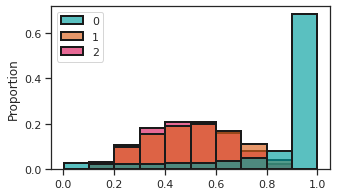

In [21]:
sns.set_style("ticks")
plt.figure(figsize=(5,3))

test1,test2,test3 = net.forward_one(Xg_test.clone().detach(),Xm_test.clone().detach(),Xs_test.clone().detach())
data = pd.concat([pd.DataFrame(np.stack([test1.cpu().detach().numpy()[:5000,0].T,test2.cpu().detach().numpy()[:5000,0].T,test3.cpu().detach().numpy()[:5000,0].T])).T,pd.DataFrame(np.stack([test1.cpu().detach().numpy()[5000:,1].T,test2.cpu().detach().numpy()[5000:,1].T,test3.cpu().detach().numpy()[5000:,1].T])).T])
sns.histplot(data=data,bins=10, palette=['#029e9e', '#d9601a','#db1a5e'], stat="proportion", alpha  = 0.65, edgecolor='k', linewidth=2,common_norm = False)